# Fashion Product Images Dataset

The growing e-commerce industry presents us with a large dataset waiting to be scraped and researched upon. In addition to professionally shot high resolution product images, we also have multiple label attributes describing the product which was manually entered while cataloging. To add to this, we also have descriptive text that comments on the product characteristics.

In [173]:
from fastai.vision import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

import torch
from torch import nn
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import re
from tqdm import tqdm

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Run once per session

! cp /gdrive/MyDrive/fashion-dataset.zip /content/ -v
!unzip fashion-dataset.zip
!rm fashion-dataset.zip

In [8]:
IMAGES_PATH = "/content/fashion-dataset/images"
STYLES_PATH = "/content/fashion-dataset/styles"
STYLES_FILE_PATH = "/content/fashion-dataset/styles.csv"
IMAGES_FILE_PATH = "/content/fashion-dataset/images.csv"

In [11]:
styles_df = pd.read_csv(STYLES_FILE_PATH, index_col=False, error_bad_lines=False)
print(styles_df.shape)
styles_df.head()

(44424, 10)


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [13]:
# Convert image names to integer

images = os.listdir("/content/fashion-dataset/images")
images_list = [re.findall(r"\d+", x)[0] for x in images]
images_list = [int(x) for x in images_list]
len(images_list)

44441

In [14]:
# Filter out df with existing images

styles_df = styles_df[styles_df.id.isin(images_list)]
styles_df.shape

(44419, 10)

In [15]:
# Split data to train and test datasets

train_df, valid_df = torch.utils.data.random_split(styles_df, [30_000, 14_419], generator=torch.Generator().manual_seed(42))

## fastai benchmark

In [16]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [17]:
path = Path('/content/fashion-dataset')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/fashion-dataset')

In [18]:
train_data, valid_data = train_test_split(styles_df)
train_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
33892,7069,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Timberland Men's Wild Cats Cycle Grey T-shirt
6939,49921,Women,Apparel,Saree,Sarees,Grey,Fall,2012.0,Ethnic,Fabindia Grey Tie & Dye Ghicha Striped Saree
39550,54904,Men,Apparel,Topwear,Tshirts,Olive,Summer,2012.0,Casual,Do u speak green Men Olive T-shirt
33745,27174,Men,Apparel,Topwear,Shirts,Blue,Summer,2012.0,Formal,Mark Taylor Men Striped Blue Shirt
15499,51937,Women,Accessories,Bags,Handbags,Teal,Summer,2016.0,Casual,Nyk Women Teal Tiny Handbag


In [19]:
train_data['label'] = train_data.masterCategory + " " + train_data.subCategory
train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,label
33892,7069,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Timberland Men's Wild Cats Cycle Grey T-shirt,Apparel Topwear
6939,49921,Women,Apparel,Saree,Sarees,Grey,Fall,2012.0,Ethnic,Fabindia Grey Tie & Dye Ghicha Striped Saree,Apparel Saree
39550,54904,Men,Apparel,Topwear,Tshirts,Olive,Summer,2012.0,Casual,Do u speak green Men Olive T-shirt,Apparel Topwear
33745,27174,Men,Apparel,Topwear,Shirts,Blue,Summer,2012.0,Formal,Mark Taylor Men Striped Blue Shirt,Apparel Topwear
15499,51937,Women,Accessories,Bags,Handbags,Teal,Summer,2016.0,Casual,Nyk Women Teal Tiny Handbag,Accessories Bags


In [20]:
# Take sample of 3000 images

np.random.seed(42)
src = (ImageList.from_df(df=train_data.sample(3000), path='/content/fashion-dataset/images', cols='id', suffix=".jpg")
    .split_by_rand_pct(0.2)
    .label_from_df(label_delim=" ", cols='label'))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [21]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

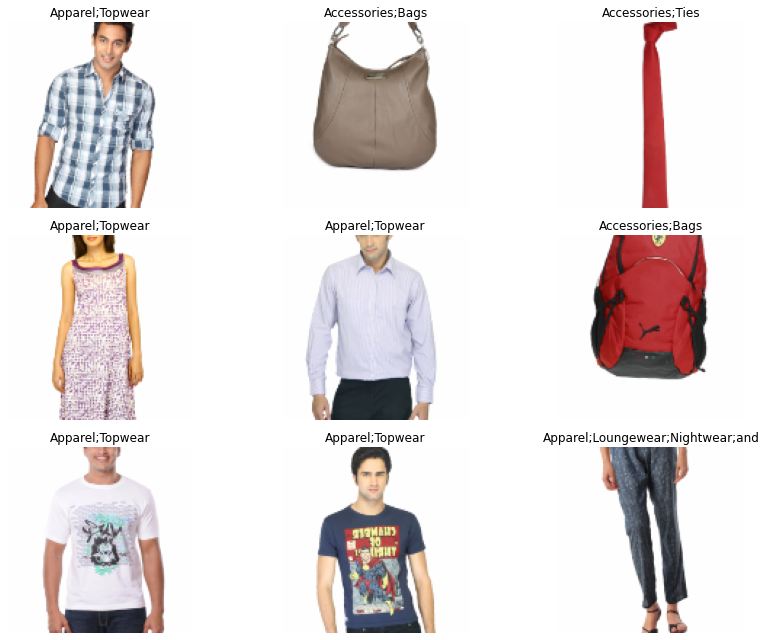

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
arch = models.resnet50

In [24]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


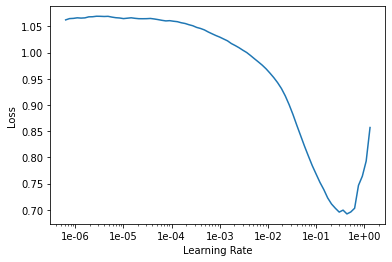

In [27]:
learn.recorder.plot()

In [28]:
lr = 0.01

In [29]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.605048,0.058493,0.978844,0.837930,03:06
1,0.223413,0.031701,0.987959,0.896253,03:06
2,0.110602,0.031003,0.989728,0.897104,03:09


In [30]:
learn.save('/content/stage-1-rn50')

In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


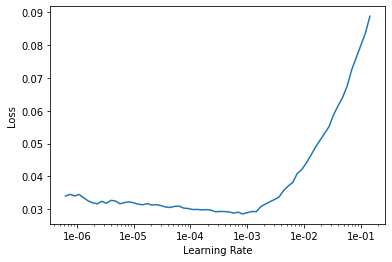

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.028449,0.025292,0.990816,0.918995,03:08
1,0.024858,0.022873,0.992993,0.934141,03:06
2,0.020300,0.020522,0.993980,0.942376,03:06
3,0.014276,0.018620,0.994422,0.947245,03:08
4,0.010760,0.018260,0.994558,0.948019,03:06


In [34]:
learn.save('/content/stage-2-rn50')

In [35]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [36]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


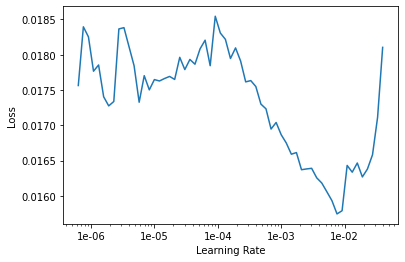

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
lr=1e-2/2

In [39]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.016020,0.017873,0.994048,0.945983,03:50
1,0.015541,0.022761,0.993265,0.942453,03:48
2,0.013306,0.018981,0.994490,0.945815,03:47
3,0.010328,0.017669,0.994626,0.946090,03:48
4,0.007677,0.017733,0.994592,0.946267,03:48


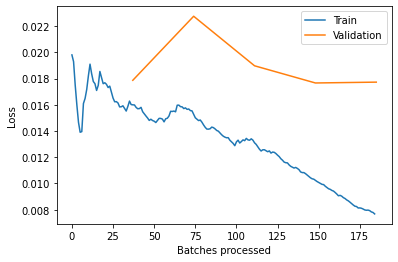

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('/content/stage-2-256-rn50')

In [43]:
learn.export("/content/export.pkl")

### Test dataset

In [49]:
valid_data['label'] = valid_data.masterCategory + " " + valid_data.subCategory

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
??ImageList.label_from_df

In [60]:
test = ImageList.from_df(df=valid_data.sample(1000), path='/content/fashion-dataset/images', cols='id', suffix=".jpg")

In [59]:
??load_learner

In [62]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [63]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [64]:
labelled_preds[:5]

['Apparel Topwear',
 'Footwear Sandal Shoes',
 'Accessories Belts',
 'Care Fragrance Personal',
 'Accessories Jewellery']

In [95]:
fnames = [int(re.findall("\d+", f)[0]) for f in learn.data.test_ds.items]

In [96]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [97]:
df.head(10)

,image_name,tags
0,7517,Apparel Topwear
1,56680,Footwear Sandal Shoes
2,50832,Accessories Belts
3,3472,Care Fragrance Personal
4,48845,Accessories Jewellery
5,1621,Apparel
6,3177,Footwear Shoes
7,3649,Footwear Shoes
8,30882,Apparel Topwear
9,7060,Accessories Bags


In [103]:
inspect_df = df.merge(valid_data[['id','label']], how='left', left_on='image_name', right_on='id')
inspect_df[inspect_df.tags != inspect_df.label]

,image_name,tags,id,label
1,56680,Footwear Sandal Shoes,56680,Footwear Shoes
3,3472,Care Fragrance Personal,3472,Accessories Accessories
5,1621,Apparel,1621,Apparel Bottomwear
12,18372,Accessories Innerwear,18372,Apparel Innerwear
15,58215,Apparel Bottomwear Saree,58215,Apparel Bottomwear
...,...,...,...,...
968,57591,Care Lips Personal,57591,Personal Care Lips
977,51802,Apparel Topwear,51802,Apparel Loungewear and Nightwear
982,46900,Care Fragrance Personal,46900,Personal Care Fragrance
992,59882,Apparel Dress Loungewear Nightwear and,59882,Apparel Topwear


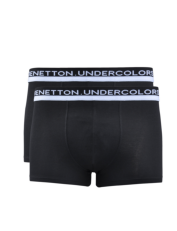

In [195]:
plt.imshow(Image.open(f"/content/fashion-dataset/images/{df.image_name.iloc[12]}.jpg"))
plt.axis('off');

# PyTorch (only master Category)


In [175]:
styles_df = pd.read_csv(STYLES_FILE_PATH, index_col=False, error_bad_lines=False)
styles_df.masterCategory = styles_df.masterCategory.astype('category')
styles_df = styles_df[styles_df.id.isin(images_list)]

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [176]:
mapper = dict(zip(styles_df.masterCategory, styles_df.masterCategory.cat.codes))
mapper

{'Accessories': 0,
 'Apparel': 1,
 'Footwear': 2,
 'Free Items': 3,
 'Home': 4,
 'Personal Care': 5,
 'Sporting Goods': 6}

In [177]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        id = row.id
        label = row.masterCategory
        path = f"/content/fashion-dataset/images/{id}.jpg"
        image = Image.open(path)
        if self.transforms:
            image = self.transforms(image)
        return image, mapper.get(label)


In [178]:
IMAGE_SIZE = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(1),
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.Normalize(mean=[.8], std=[.5])
])

In [179]:
train_dataset = TrainDataset(styles_df, train_df.indices, transforms=transform)
valid_dataset = TrainDataset(styles_df, valid_df, transforms=transform)

torch.Size([1, 128, 128])
2


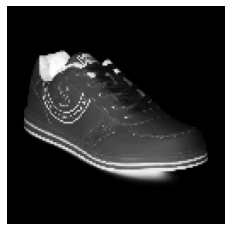

In [180]:
img, label = train_dataset[155]
print(img.shape)
print(label)
plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
plt.axis('off');

In [185]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=True, num_workers=4) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [186]:
input_size = IMAGE_SIZE ** 2
hidden_size = [256, 64]
output_size = 7

model = nn.Sequential(
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0], hidden_size[1]),
    nn.ReLU(),
    nn.Linear(hidden_size[1], output_size),
    nn.LogSoftmax(dim=1)
)
model

Sequential(
  (0): Linear(in_features=16384, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=7, bias=True)
  (5): LogSoftmax(dim=1)
)

In [187]:
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [188]:
if torch.cuda.is_available():
    model = model.cuda()
    optimizer = optimizer

In [189]:
epochs = 1

for e in range(epochs):
    train_running_loss = 0.0
    valid_running_loss = 0.0

    for images, labels in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.view(-1, 128*128)
        labels =labels.long()
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() / BATCH_SIZE

    with torch.no_grad():
        for images, labels in tqdm(valid_dataloader, position=0, leave=True, desc='Validation'):
            images = images.view(-1, 128*128)
            labels =labels.long()
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            output = model(images)
            loss = criterion(output, labels)

            valid_running_loss += loss.item() / BATCH_SIZE

    print('[Epoch: %d, Iteration: %5d] Train Loss: %.5f  |  Valid Loss: %.5f' % (e + 1, i + 1, train_running_loss, valid_running_loss))
    running_loss = 0.0

print('Finished Training')

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 469/469 [30:03<00:00,  3.85s/it]

100%|██████████| 226/226 [14:27<00:00,  3.84s/it]

[Epoch: 1, Iteration:     1] Train Loss: 1.88067  |  Valid Loss: 0.51295
Finished Training
